#**HW 2: Optimize and train Deep Models**

In this homework, we will explore how to develop a simple Deep Neural Network for a classification problem. We will explore two common libraries: TensorFlow and Keras.
Then we will explore how to face a well known problem that is common to encounter during the training phase: the Overfitting.
Finally, we will study how to perform a fair model selection.
Hint: Before starting the exercise take a look at how Tensorflow and Keras are designed.  https://keras.io/

##Exercise 2.1: Image Classficiation with Tensorflow and Keras

In this first exercise we will develop a 3 layers Neural Network to perfrom classification.

Let's start importing the libraries we will need and setting a couple of environmental variables.


In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
from tensorflow import keras  # tf.keras
import time

import logging
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" 



tf.random.set_seed(42)
# os.environ['TF_DETERMINISTIC_OPS']='1'

### Load Data: IMDB dataset

In this HW, we use the IMDB dataset that can be easily downloaded using Keras. The dataset contains 50,000 movie reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes. For convenience, the words are indexed by the overall frequency in the dataset, so that for example the integer "3" encodes the 3rd most frequent word in the data. For testing purposes, we will only consider the first 10,000  most common words.
By default, the load_data method returns a breakdown of the dataset into training and test sets. Both these sets contain 25,000 samples. To also have a validation set, we split the test set in half.



In [2]:
num_words = 1000
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=num_words)
(X_valid, X_test) = X_test[:12500], X_test[12500:]
(y_valid, y_test) = y_test[:12500], y_test[12500:]

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In this HW we will consider a Deep Neural Network. The IMDB data consists in reviews, each one composed by a seqeunce of words. In order to encode each review in a single tensor with a fixed number of elements, we will use multi-hot encoding. Multi-hot-encoding our lists means turning them into vectors of 0s and 1s. Concretely, this would mean for instance turning the sequence [3, 5] into a 10,000-dimensional vector that would be all-zeros except for indices 3 and 5, which would be ones. The obtained input representation indicates which words are present (at least one time) in the sentence.

 

In [3]:
def multi_hot_encoder(dataset, num_word):
  dataset_multi_hot=[]
  for sequence in dataset:
    index, _ = tf.unique(sequence)
    dataset_multi_hot.append(tf.reduce_max(tf.one_hot(index-1, num_word, dtype=tf.int32), axis=0))
  dataset_multi_hot = tf.stack(dataset_multi_hot)
  return dataset_multi_hot

X_train = multi_hot_encoder(X_train,num_words)
X_test = multi_hot_encoder(X_test,num_words)
X_valid = multi_hot_encoder(X_valid,num_words)

### Define the model:

Let's build a Sequential model (keras.models.Sequential) and add four layers to it by calling its add() method:


*   a input layer (tf.keras.Input) that is the first layer in your model. With this layer you should specify the input_shape argument, leaving out the batch size: (num_words,);
*  a Dense layer (keras.layers.Dense) with 16 neurons, and the "relu" activation function;
* another Dense layer with 16 neurons, also with the "relu" activation function;
* a final Dense layer with 1 output neurons, and with the "sigmoid" activation (since we considering a binary classification task).

In [4]:
model = keras.models.Sequential()
model.add(tf.keras.Input(shape=(num_words,)))
model.add(keras.layers.Dense(16, activation="relu"))
model.add(keras.layers.Dense(16, activation="relu"))
model.add(keras.layers.Dense(1, activation="sigmoid"))



Call the model's summary() method to check if the model has been built correctly. Also, try using keras.utils.plot_model() to save an image of your model's architecture.

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                16016     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 16,305
Trainable params: 16,305
Non-trainable params: 0
_________________________________________________________________


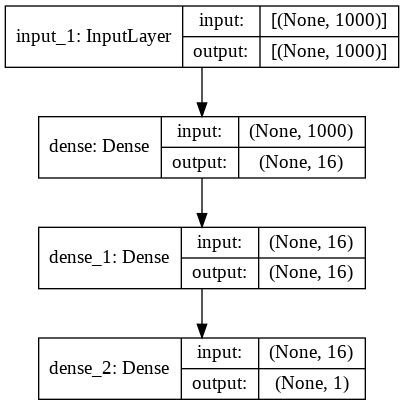

In [6]:
keras.utils.plot_model(model, "my_imdb_model.png", show_shapes=True)

As you can see, the first dimension of each layer is not defined (?), indeed this dimension in each layer is variable and depends on the batch size.

Instaed of using *add()* method it is also possibile to define the model using the following syntax

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                16016     
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 16,305
Trainable params: 16,305
Non-trainable params: 0
_________________________________________________________________


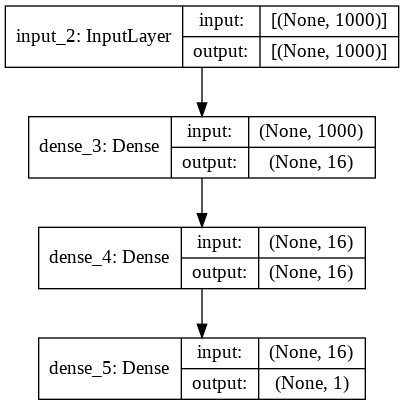

In [7]:
model = keras.models.Sequential([
    tf.keras.Input(shape=(num_words,)),
    keras.layers.Dense(16, activation="relu"),
    keras.layers.Dense(16, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])
model.summary()
keras.utils.plot_model(model, "my_imdb_model.png", show_shapes=True)

### Optimize the model:

After the model has been created, you must call its compile() method to specify the loss function and the optimizer to use.

Since the model performs a binary classification task, we use the bynary cross-entropy as loss. As optimizer we use Adam.

Moreover, you can optionally specify a list of additional metrics that should be measured during training. In this case we specify metrics=["accuracy"].

In [8]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              metrics=["accuracy"])

Now our model is ready to be trained. Call its fit() method, passing to it the input features (X_train) and the target classes (y_train). Set the number of epochs to 20. 
In order to validate our model we will also pass the validation data by setting validation_data=(X_valid, y_valid). Keras will compute the loss and the additional metrics (the accuracy in this case) on the validation set at the end of each epoch. If the loss on the training set is much lower than the one on the validation set, your model is probably overfitting the training set. Note: the fit() method will return a History object containing training stats.

In [9]:
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
782/782 [==============================] - 3s 3ms/step - loss: 0.6691 - accuracy: 0.5917 - val_loss: 0.5086 - val_accuracy: 0.7899
Epoch 2/20
782/782 [==============================] - 2s 2ms/step - loss: 0.4609 - accuracy: 0.8105 - val_loss: 0.3856 - val_accuracy: 0.8406
Epoch 3/20
782/782 [==============================] - 2s 2ms/step - loss: 0.3556 - accuracy: 0.8580 - val_loss: 0.3534 - val_accuracy: 0.8515
Epoch 4/20
782/782 [==============================] - 2s 2ms/step - loss: 0.3298 - accuracy: 0.8647 - val_loss: 0.3407 - val_accuracy: 0.8543
Epoch 5/20
782/782 [==============================] - 2s 2ms/step - loss: 0.3148 - accuracy: 0.8714 - val_loss: 0.3377 - val_accuracy: 0.8555
Epoch 6/20
782/782 [==============================] - 2s 2ms/step - loss: 0.3055 - accuracy: 0.8712 - val_loss: 0.3344 - val_accuracy: 0.8565
Epoch 7/20
782/782 [==============================] - 2s 2ms/step - loss: 0.2989 - accuracy: 0.8771 - val_loss: 0.3344 - val_accuracy: 0.8562
Epoch 

Let's plot the loss and the accuracy trends on both training and validation sets. We define the "plot_learning_acc_and_loss" function because we will reuse it in the next steps.

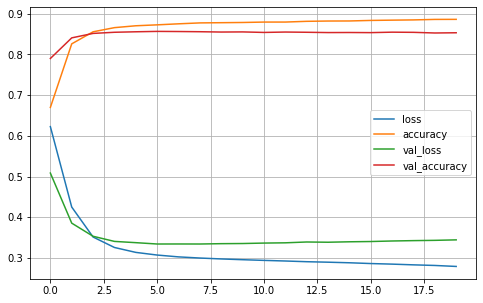

In [10]:
def plot_learning_acc_and_loss(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.show()
plot_learning_acc_and_loss(history)

### [TO COMPLETE] Evaluate the model:

Now, our model has been optimized on the training set, and as you can see the performance on the validation set in quite similar (so it does not overfit the training data). Let's now evaluate the performance of our model using the test set.

In [11]:
model.evaluate(X_test, y_test)

391/391 [==============================] - 0s 1ms/step - loss: 0.3227 - accuracy: 0.8662


[0.32265692949295044, 0.8662400245666504]

[TO COMPLETE] Explain why it is important to use test and validation, and why it is important to evaluate the model on the test set instead of the validation set. Finally, explain which is the usefulness of the validation set. Insert the discussion in this cell.

ANSWER:
Assuming clear why we slipt the data in train and valid set, the split in train, valid and test set is very easy. The validation set is used to make sure we dont overfit (crudely: "when train loss is getting better and valid_loss worse"). The test set is meant to be a set with completly unseen data in order to confirm the predictive power of the network (obtain after the training, in which we used both train and valid set).

## [TO COMPLETE] Exercise 2.2: Overfiting

A common problem that occurs when you train a deep neural network is overfittig. Overfitting occurs when you achieve a good fit of your model on the training data, while it does not generalize well on new, unseen data. In other words, the model learned patterns specific to the training data, which are irrelevant in other data.
As we have seen in the previous exercise, our model does not overfit the training data. In this exercise, we try to modify the training parameters in order to have a model that overfits.
Overfitting can have many causes and usually is a combination of some of them, for instance: too many parameters/ layers, too few training samples, wrong learning rate (usualy too high), etc..

[TO COMPLETE] In the next cell define a new model (similar to the previuos one) that overfits the training data; then plot the trend of the loss in training and validation set.

In [12]:
model = keras.models.Sequential([
    tf.keras.Input(shape=(num_words,)),
    keras.layers.Dense(16, activation="relu"),
    keras.layers.Dense(32, activation="relu"),# BIGGER NUMBER OF NEURONS, 16-->32
    keras.layers.Dense(1, activation="sigmoid")
])
model.summary()
#[TO COMPLETE] modify the previuos model in order to obtain a new mdel that overfit the training data

model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=1e-4),#[TO COMPLETE] learning rate, USED SAME AS BEFORE
              metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=40,#[TO COMPLETE] DOUBLED, 20-->40
                    validation_data=(X_valid, y_valid))

print("Model Evaluation")
model.evaluate(X_test, y_test)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 16)                16016     
_________________________________________________________________
dense_7 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 16,593
Trainable params: 16,593
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
782/782 [==============================] - 2s 2ms/step - loss: 0.6657 - accuracy: 0.5928 - val_loss: 0.4911 - val_accuracy: 0.7922
Epoch 2/40
782/782 [==============================] - 2s 2ms/step - loss: 0.4436 - accuracy: 0.8141 - val_loss: 0.3782 - val_accuracy: 0.8386
Epoch 3/40
782/782 [==============================] - 2s 2ms/step - loss: 0.3478 - accuracy: 0.8

[0.4005816876888275, 0.8463199734687805]

Define the plot_learning_curves function that plots inly the losses (not the accuracy).

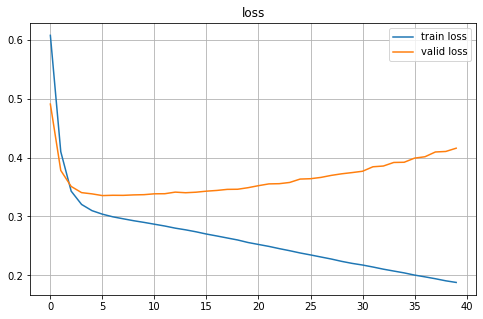

In [13]:
def plot_learning_curves(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history.epoch,history.history['loss'], label='train loss')
    plt.plot(history.epoch,history.history['val_loss'], label='valid loss')
    plt.legend()
    plt.title('loss')
    plt.grid(True)
    plt.show()
plot_learning_curves(history)

### [TO COMPLETE] L1 norm

One possible way to solve the overitting issue is by using regularization methods. The two most common regularization methods in Deep Learning are the L1-norm regularization and the L2-norm regularization. Both These techniques are based on limiting the capacity of models, by adding a parameter norm penalty to the objective function $\mathcal{J}$:
$$
\hat{\mathcal{J}}(\theta,\mathbf{X},\mathbf{y}) = \mathcal{J}(\theta,\mathbf{X},\mathbf{y}) + \alpha \Omega(\theta)
$$
where $\alpha$ is a hyperparameter that weighs the relative contribution of the norm penalty $\Omega$.
Lets start by considering the L1-norm regularization where the regularization term is defined as:
$$
 \Omega(\theta)=||\mathbf{W}||_1=\sum_i |\mathbf{w}|
$$
Let's find the values for the $\alpha$ parameters that allow to remove the overfitting effect.

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 16)                16016     
_________________________________________________________________
dense_10 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 16,593
Trainable params: 16,593
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
782/782 [==============================] - 3s 2ms/step - loss: 1.2487 - accuracy: 0.6074 - val_loss: 0.8238 - val_accuracy: 0.8053
Epoch 2/40
782/782 [==============================] - 2s 2ms/step - loss: 0.7448 - accuracy: 0.8238 - val_loss: 0.6216 - val_accuracy: 0.8382
Epoch 3/40
782/782 [==============================] - 2s 2ms/step - loss: 0.5846 - accuracy: 0.8

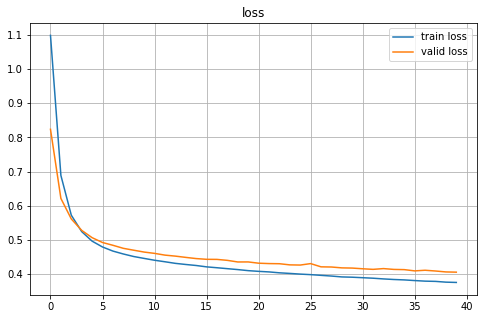

In [14]:
#In Keras is neccesary to add the regularizer by using the attribute kernel_regularizer
#to each layer whose weights will be considered in the Omega function.
#is it also possibile to consider the bias by using the attribute bias_regularizer 
#tf.keras.regularizers.l1(alpha) perfroms the L1-norm regularization

#[TO COMPLETE] copy the model that you previously defined that overfits the --->done
#trainnig data, and add the L1-norm regularization. Use a proper value for the
#alpha hyper-parameter, that prevents the model from overfitting. The results  
#reached by the model in terms of loss and accuracy (in all data sets) should be
#comparable with the ones obtained by the initial model defined in Exercise 2.1 

#In general, a layer that exploits L1-norm regularization is defined as follows:

#model.add(keras.layers.Dense(units=[TO COMPLETE], activation=[TO COMPLETE], kernel_regularizer=tf.keras.regularizers.l1([TO COMPLETE]))) -->done

model = keras.models.Sequential([
    tf.keras.Input(shape=(num_words,)),
    keras.layers.Dense(units=16, activation="relu", kernel_regularizer=tf.keras.regularizers.l1(1e-3)), 
    keras.layers.Dense(units=32, activation="relu", kernel_regularizer=tf.keras.regularizers.l1(1e-3)), 
    keras.layers.Dense(1, activation="sigmoid")
])
model.summary()
#[TO COMPLETE] -->done


model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=1e-4),#[TO COMPLETE] learning rate, -->done
              metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=40,#[TO COMPLETE] epochs,-->done
                    validation_data=(X_valid, y_valid))

print("Model Evaluation")
model.evaluate(X_test, y_test)
plot_learning_curves(history)

### [TO COMPLETE] L2-norm

L2-norm regularization is also known as weight decay. This strategy drives the weights closer to the origin by adding the regularization term omega which is defined as:
$$
 \Omega(\theta)=\frac{1}{2}||\mathbf{W}||_2^2
$$

Let's find the values for the $\alpha$ parameters that allow removing remove the overfitting effect with L2-norm.

Epoch 1/40
782/782 [==============================] - 2s 2ms/step - loss: 1.0875 - accuracy: 0.6589 - val_loss: 0.7482 - val_accuracy: 0.8196
Epoch 2/40
782/782 [==============================] - 2s 2ms/step - loss: 0.6865 - accuracy: 0.8339 - val_loss: 0.5831 - val_accuracy: 0.8458
Epoch 3/40
782/782 [==============================] - 2s 2ms/step - loss: 0.5465 - accuracy: 0.8595 - val_loss: 0.5240 - val_accuracy: 0.8486
Epoch 4/40
782/782 [==============================] - 2s 2ms/step - loss: 0.4959 - accuracy: 0.8629 - val_loss: 0.4905 - val_accuracy: 0.8540
Epoch 5/40
782/782 [==============================] - 2s 2ms/step - loss: 0.4626 - accuracy: 0.8683 - val_loss: 0.4706 - val_accuracy: 0.8554
Epoch 6/40
782/782 [==============================] - 2s 2ms/step - loss: 0.4418 - accuracy: 0.8687 - val_loss: 0.4563 - val_accuracy: 0.8577
Epoch 7/40
782/782 [==============================] - 2s 2ms/step - loss: 0.4262 - accuracy: 0.8743 - val_loss: 0.4480 - val_accuracy: 0.8567
Epoch 

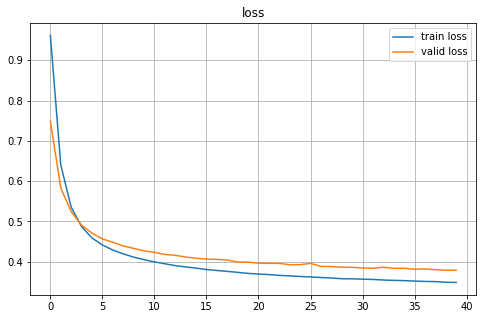

In [15]:
#[TO COMPLETE] insert the model that you previously defined that overfit the 
#trainig data, and add the L2-norm regularization. Use proper values for the
#alpha hyper-parameters, that prevents the model from overfitting. The results  
#reached by the model in terms of loss and accuracy (in all data sets) should be
#comparable with the ones obtained by the initial model defined in Exercise 2.1

#In general, a layer that exploits L2-norm regularization is defined as follow:

#model.add(keras.layers.Dense(units=[TO COMPLETE], activation=[TO COMPLETE],kernel_regularizer=tf.keras.regularizers.l2([TO COMPLETE]))) 

model = keras.models.Sequential([
    tf.keras.Input(shape=(num_words,)),
    keras.layers.Dense(units=16, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(1e-2)), 
    keras.layers.Dense(units=32, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(1e-2)), 
    keras.layers.Dense(1, activation="sigmoid")
])
#[TO COMPLETE] -->done

model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=1e-4),#[TO COMPLETE] learning rate -->done
              metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=40,#[TO COMPLETE] epochs -->done
                    validation_data=(X_valid, y_valid))

print("Model Evaluation")
model.evaluate(X_test, y_test)
plot_learning_curves(history)

###[TO COMPLETE] Early stopping

Early Stopping is a form of regularization used to avoid overfitting. It is designed to monitor the generalization error of one model and stop training when generalization error begins to degrade. In order to evaluate the generalization error, early stopping requires that a validation dataset is evaluated during training. Then, when the validation error does not improve for a specific number of epochs (patience hyper-parameter), it stops the training phase.

Epoch 1/40
782/782 [==============================] - 2s 2ms/step - loss: 0.6563 - accuracy: 0.6081 - val_loss: 0.4533 - val_accuracy: 0.8075
Epoch 2/40
782/782 [==============================] - 2s 2ms/step - loss: 0.4136 - accuracy: 0.8285 - val_loss: 0.3652 - val_accuracy: 0.8417
Epoch 3/40
782/782 [==============================] - 2s 2ms/step - loss: 0.3350 - accuracy: 0.8617 - val_loss: 0.3465 - val_accuracy: 0.8514
Epoch 4/40
782/782 [==============================] - 2s 2ms/step - loss: 0.3202 - accuracy: 0.8665 - val_loss: 0.3386 - val_accuracy: 0.8550
Epoch 5/40
782/782 [==============================] - 2s 2ms/step - loss: 0.3080 - accuracy: 0.8725 - val_loss: 0.3371 - val_accuracy: 0.8562
Epoch 6/40
782/782 [==============================] - 2s 2ms/step - loss: 0.2996 - accuracy: 0.8767 - val_loss: 0.3350 - val_accuracy: 0.8570
Epoch 7/40
782/782 [==============================] - 2s 2ms/step - loss: 0.2952 - accuracy: 0.8789 - val_loss: 0.3358 - val_accuracy: 0.8566
Model 

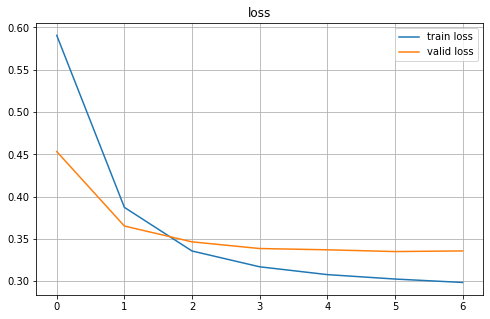

In [16]:
#[TO COMPLETE] insert the model that you previously defined that overfit the -->done
#trainnig data
model = keras.models.Sequential([
    tf.keras.Input(shape=(num_words,)),
    keras.layers.Dense(16, activation="relu"),
    keras.layers.Dense(32, activation="relu"),# BIGGER NUMBER OF NEURONS, 16-->32
    keras.layers.Dense(1, activation="sigmoid")
])


model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=1e-4),#[TO COMPLETE] learning rate -->done

              metrics=["accuracy"])

#Let's define a log dir in order to save the checkpoint file
logdir = os.path.join(os.curdir, "my_logs", "run_{}".format(time.time()))

#In Keras the Eraly stopping is manage by using the callbacks argument.
callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.EarlyStopping(patience=1),#[TO COMPLETE] play with patience and find the value that prevents the model from overfitting. -->done


    #Saving the checkpoints file allows to load the "best" model when the Early 
    #stopping detect that the generalization error degrade (after 'patience' epochs)
    keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True),
]

history = model.fit(X_train, y_train, epochs=40,#[TO COMPLETE] epochs
                    validation_data=(X_valid, y_valid),
                    callbacks=callbacks)

print("Model Evaluation")
#The early stopping stopped training after few epochs without progress, so your
#model may already have started to overfit the training set. Since the 
#ModelCheckpoint callback only saved the best models (on the validation set) the
#last saved model is the best on the validation set.
model = keras.models.load_model("my_mnist_model.h5")
model.evaluate(X_test, y_test)
plot_learning_curves(history)

## Exercise 2.3: Model Selection

Hyperparameters are the parameters of the learning method itself which we have to specify a priori, i.e., before model fitting. In contrast, model parameters are parameters which arise as a result of the fit (the network weights). The aim of model selection is selecting the best hyperparameters for our deep network. Finding the right hyperparameters for a model can be crucial for the model performance on given data. For istance lets consider our model trained by using different values for the learning rate: 

In [17]:
learning_rates = [1e-4, 1e-2, 1e-1]

In [18]:
histories = []
for learning_rate in learning_rates:
    model = keras.models.Sequential([
                                    tf.keras.Input(shape=(num_words,)),
                                    keras.layers.Dense(16, activation="relu"),
                                    keras.layers.Dense(16, activation="relu"),
                                    keras.layers.Dense(1, activation="sigmoid")
                                     ])
    model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=["accuracy"])
              
    callbacks = [keras.callbacks.EarlyStopping(patience=2)]

    history = model.fit(X_train, y_train,
                        validation_data=(X_valid, y_valid), epochs=10,
                        callbacks=callbacks)
    histories.append(history)
    print("evaluation on test set")
    model.evaluate(X_test, y_test)

Epoch 1/10
782/782 [==============================] - 2s 2ms/step - loss: 0.6654 - accuracy: 0.5814 - val_loss: 0.4753 - val_accuracy: 0.8074
Epoch 2/10
782/782 [==============================] - 2s 2ms/step - loss: 0.4283 - accuracy: 0.8266 - val_loss: 0.3704 - val_accuracy: 0.8462
Epoch 3/10
782/782 [==============================] - 2s 2ms/step - loss: 0.3395 - accuracy: 0.8621 - val_loss: 0.3485 - val_accuracy: 0.8534
Epoch 4/10
782/782 [==============================] - 2s 2ms/step - loss: 0.3216 - accuracy: 0.8653 - val_loss: 0.3393 - val_accuracy: 0.8567
Epoch 5/10
782/782 [==============================] - 2s 2ms/step - loss: 0.3102 - accuracy: 0.8740 - val_loss: 0.3378 - val_accuracy: 0.8571
Epoch 6/10
782/782 [==============================] - 2s 2ms/step - loss: 0.3019 - accuracy: 0.8756 - val_loss: 0.3353 - val_accuracy: 0.8562
Epoch 7/10
782/782 [==============================] - 2s 2ms/step - loss: 0.2960 - accuracy: 0.8788 - val_loss: 0.3356 - val_accuracy: 0.8562
Epoch 

Let's plot the results

Learning rate: 0.0001


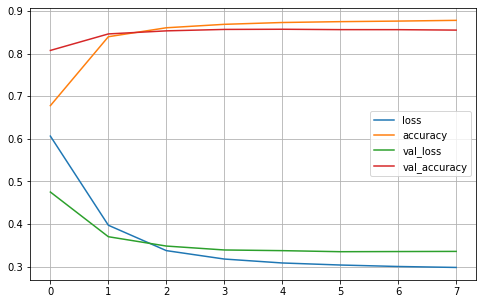

Learning rate: 0.01


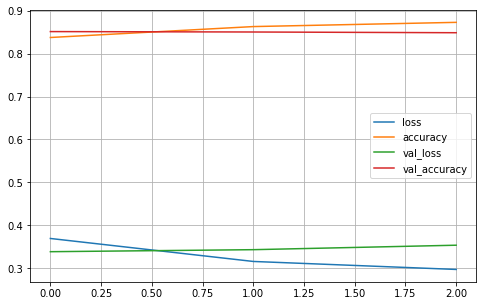

Learning rate: 0.1


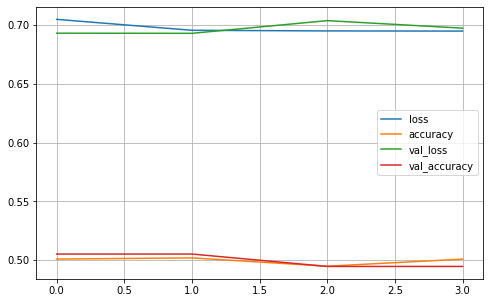

In [19]:
for learning_rate, history in zip(learning_rates, histories):
    print("Learning rate:", learning_rate)
    plot_learning_acc_and_loss(history)

### [TO COMPLETE] GRID Search:

Since a deep net has many hyperparameters, in order to find the best ones, we have to consider all the possible combinations of all of the possible values. One common method to perform this complex task is Grid-Search.
Given a set of values for each hyper-parameter, Grid-Search will build a model on each parameter combination possible. It iterates through every parameter combination and stores a model for each combination. Finally, the model that obtained the best result on the validation set will be select.

In order to perfrom Grid-Search we will use the GridSearchCV method from scikit-learn.

Let's Create a build_model() function that takes two arguments, n_neurons, learning_rate, and builds, compiles and returns a model with the given number of of neurons and the given learning rate.
In order to limit the time requirements of the process we will consider only these two hyper-paramters.

[TO COMPLETE] in the following code cell define the build_model function.

In [20]:
def build_model(n_units=30, learning_rate=1e-3):
    # The function has to build a model similar to the ones we used in previuous execises:
    #- a input layer 
    #- one or two Dense layers composed of n_units and that exploit Relu activation function 
    #- the output layer that uses the sigmoid activation function
    # Then, the model has to be compiled.
    model = keras.models.Sequential([
                                    tf.keras.Input(shape=(num_words,)),
                                    keras.layers.Dense(n_units, activation="relu"),
                                    keras.layers.Dense(n_units, activation="relu"),
                                    keras.layers.Dense(1, activation="sigmoid")
                                     ])
     
    model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=["accuracy"])
    
    
    
    return model

    
#Create a keras.wrappers.scikit_learn.KerasRegressor and pass the build_model 
#function to the constructor. This gives you a Scikit-Learn compatible predictor
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

Let's define the lists of hyper-parameters' values. Also in this case, we use a very limited size lists, but in a real-world scenario a reasonable amount of possible values should be considered (try to add some values and check how much the time required to perform the Grid-Search increases)

In [21]:
param_distribs = {
    "n_units": [16, 32],# [TO COMPLETE] insert a list that contains few (2 or 3) reasonable value
    "learning_rate": [1e-4, 1e-3] #[TO COMPLETE] insert a list that contains few (2 or 3) reasonable values
    #Check how the time required to perform GRID search increases when increasing the number of values for each hyper-parameter.
}

Use a sklearn.model_selection.GridSearchCV to search the hyperparameter space of your KerasRegressor

In [22]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(keras_reg, param_distribs)

Run the Grid-Search

In [23]:

grid_search.fit(X_train.numpy(), y_train, epochs=5,#The number of epochs can be modified (check what happens by increasing it)
                validation_data=(X_valid.numpy(), y_valid))

Epoch 1/5
625/625 [==============================] - 2s 2ms/step - loss: 0.6724 - accuracy: 0.5868 - val_loss: 0.5248 - val_accuracy: 0.7769
Epoch 2/5
625/625 [==============================] - 1s 2ms/step - loss: 0.4645 - accuracy: 0.8050 - val_loss: 0.3999 - val_accuracy: 0.8293
Epoch 3/5
625/625 [==============================] - 1s 2ms/step - loss: 0.3655 - accuracy: 0.8499 - val_loss: 0.3650 - val_accuracy: 0.8448
Epoch 4/5
625/625 [==============================] - 1s 2ms/step - loss: 0.3295 - accuracy: 0.8639 - val_loss: 0.3515 - val_accuracy: 0.8506
Epoch 5/5
157/157 [==============================] - 0s 1ms/step - loss: 0.3412 - accuracy: 0.8572
Epoch 1/5
625/625 [==============================] - 2s 2ms/step - loss: 0.6614 - accuracy: 0.5932 - val_loss: 0.4897 - val_accuracy: 0.7880
Epoch 2/5
625/625 [==============================] - 1s 2ms/step - loss: 0.4447 - accuracy: 0.8115 - val_loss: 0.3875 - val_accuracy: 0.8354
Epoch 3/5
625/625 [==============================] - 1s

GridSearchCV(cv=None, error_score=nan,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7fdcf814e090>,
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.0001, 0.001], 'n_units': [16, 32]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Print the best hyper-parameters, and evealuate the best model on the test set.

In [24]:
print(grid_search.best_params_)

model = grid_search.best_estimator_.model
model.evaluate(X_test, y_test)

{'learning_rate': 0.0001, 'n_units': 32}
391/391 [==============================] - 0s 1ms/step - loss: 0.3192 - accuracy: 0.8641


[0.31922876834869385, 0.864080011844635]